# Catcher Framing

## 7.2 Acquiring Pitch-Level Data

Reading data from the 2022 season:

For Statcast data, I am using the `pybaseball` library to pull data used in catcher framing analysis. This library is Python equivalent of R's `baseballr` package used in the book.

- **GitHub:** [github.com/jldbc/pybaseball](https://github.com/jldbc/pybaseball)

Pulling 2022 Statcast data

In [1]:
import pandas as pd
import pybaseball as pyb
from pybaseball import cache
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# pybaseball docs recommend adding cache to avoid redownloading
cache.enable()

sc2022 = pyb.statcast(start_dt='2022-03-01', end_dt='2022-11-30')

def categorize_outcome(description):
    balls = ['ball', 'blocked_ball', 'pitchout', 'hit_by_pitch']
    swings = ['swinging_strike', 'swinging_strike_blocked', 'foul', 
              'foul_bunt', 'foul_tip', 'hit_into_play', 'missed_bunt']
    if description in balls:
        return 'ball'
    elif description in swings:
        return 'swing'
    elif description == 'called_strike':
        return 'called_strike'
    else:
        return None

sc2022['Outcome'] = sc2022['description'].apply(categorize_outcome)

sc2022['Home'] = (sc2022['inning_topbot'] == 'Bot').astype(int)

sc2022['Count'] = sc2022['balls'].astype(str) + '-' + sc2022['strikes'].astype(str)

sc2022_taken = sc2022[sc2022['Outcome'] != 'swing'].copy()

print(f"Total pitches: {len(sc2022):,}")
print(f"Taken pitches: {len(sc2022_taken):,}")

This is a large query, it may take a moment to complete
Skipping offseason dates
Skipping offseason dates


100%|██████████| 246/246 [00:23<00:00, 10.59it/s]


Total pitches: 775,330
Taken pitches: 401,507


Data is filtered for only "taken" pitches (balls and called strikes) because catcher framing only affects umpire judgment on pitches the batter does not swing at.


Create 50,000 pitch sample of 2022 data and save output for analysis.  I used parquet over CSV in this case to reduce file size

In [2]:
taken = sc2022_taken.sample(n=50000, random_state=42)

print(f"Total pitches: {len(sc2022):,}")
print(f"Taken pitches: {len(sc2022_taken):,}")
print(f"Sample size for analysis: {len(taken):,}")

taken.to_parquet('../data/statcast_2022_sample.parquet', index=False)


Total pitches: 775,330
Taken pitches: 401,507
Sample size for analysis: 50,000


## 7.3 Where Is the Strike Zone?

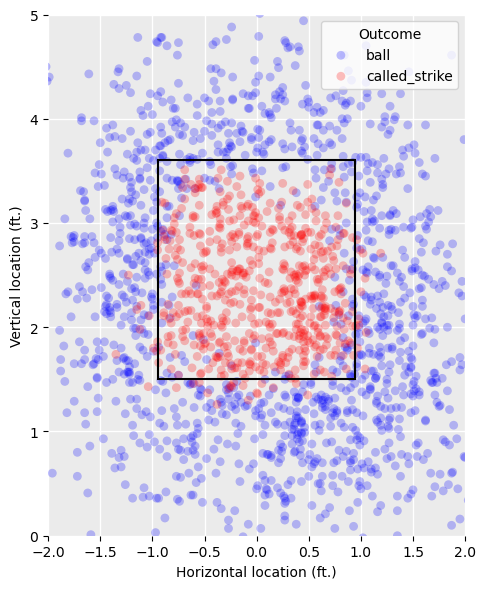

In [3]:
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from src.plotting_utils import add_strike_zone

# Further sample only 2000 rows for plotting
sample_n = sc2022_taken.sample(n=2000, random_state=42)

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor('#EBEBEB')

colors = {'ball': 'blue', 'called_strike': 'red'}

for outcome in ['ball', 'called_strike']:
    subset = sample_n[sample_n['Outcome'] == outcome]
    ax.scatter(
        subset['plate_x'], 
        subset['plate_z'],
        c=colors[outcome],
        alpha=0.25,
        s=40,
        label=outcome,
        edgecolors='none'
    )

add_strike_zone(ax, facecolor='none')

ax.grid(True, color='white', linewidth=1, zorder=0)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)

ax.set_aspect('equal')

ax.legend(title='Outcome', loc='upper right', frameon=True, framealpha=0.8)

plt.tight_layout()
plt.show()

Many pitches outside the strike zone are called strikes. Catcher framing influences these borderline calls.

Compute the probability that a pitch taken in each Statcast zone will be called a strike

In [4]:
zones = sample_n.groupby('zone').agg(
    N=('zone', 'size'),
    right_edge=('plate_x', lambda x: min(1.5, x.max())),
    left_edge=('plate_x', lambda x: max(-1.5, x.min())),
    top_edge=('plate_z', lambda x: min(5, x.quantile(0.95))),
    bottom_edge=('plate_z', lambda x: max(0, x.quantile(0.05))),
    strike_pct=('Outcome', lambda x: (x == 'called_strike').sum() / len(x)),
    plate_x=('plate_x', 'mean'),
    plate_z=('plate_z', 'mean')
).reset_index()

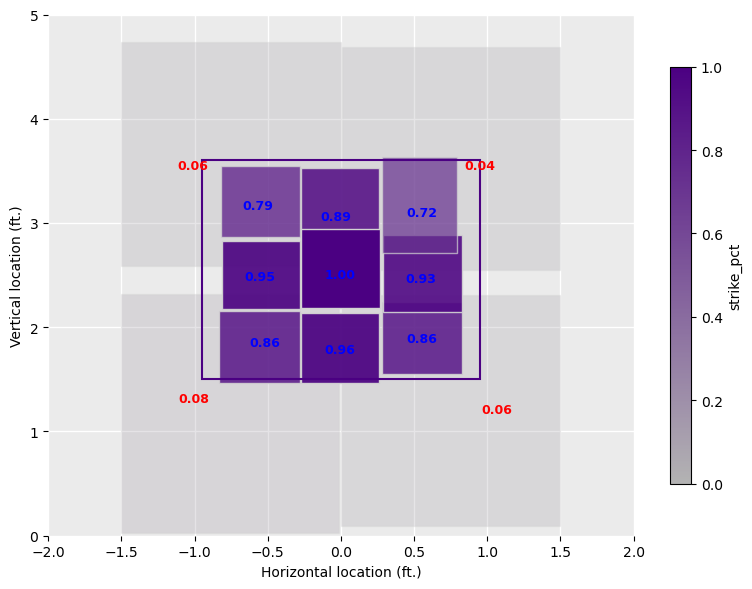

In [5]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap, Normalize

fig, ax = plt.subplots(figsize=(8, 6))

ax.set_facecolor('#EBEBEB')

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#B3B3B3', '#4B0082'])
norm = Normalize(vmin=0, vmax=1)

zones_sorted = zones.sort_values('N', ascending=False)

for _, row in zones_sorted.iterrows():
    rect = Rectangle(
        (row['left_edge'], row['bottom_edge']),
        width=row['right_edge'] - row['left_edge'],
        height=row['top_edge'] - row['bottom_edge'],
        facecolor=cmap(norm(row['strike_pct'])),
        edgecolor='lightgray',
        alpha=max(0.3, row['strike_pct']),
        linewidth=1,
        zorder=1
    )
    ax.add_patch(rect)

for _, row in zones.iterrows():
    text_color = 'red' if row['strike_pct'] < 0.5 else 'blue'
    ax.text(
        row['plate_x'], 
        row['plate_z'],
        f"{row['strike_pct']:.2f}",
        ha='center', 
        va='center',
        fontsize=9,
        color=text_color,
        fontweight='bold',
        zorder=3
    )

add_strike_zone(ax, facecolor='none', edgecolor='#4B0082')
ax.patches[-1].set_zorder(2)

ax.grid(True, color='white', linewidth=1, zorder=0)
ax.set_axisbelow(True)

for spine in ax.spines.values():
    spine.set_visible(False)

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, label='strike_pct', shrink=0.8)

plt.tight_layout()
plt.show()

- Center of zone: Near-certain strike calls (89-100%)
- Corners: Lower certainty (72-86%) — potential for catcher framing impact
- Outside zone: Strike probability drops to 4-8%

## 7.4 Modeling Called Strike Percentage

In [6]:
from pygam import LogisticGAM, te

taken_clean = taken.dropna(subset=['plate_x', 'plate_z', 'Outcome']).copy()

y = (taken_clean['Outcome'] == 'called_strike').astype(int)
X = taken_clean[['plate_x', 'plate_z']].values

strike_mod = LogisticGAM(te(0, 1)).fit(X, y)

taken_clean['fitted'] = strike_mod.predict_mu(X)

hats = taken_clean.sample(n=min(10000, len(taken_clean)), random_state=42)

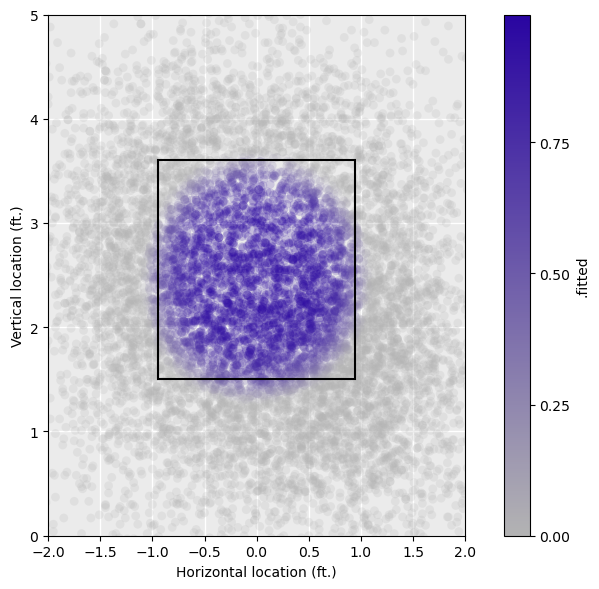

In [7]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap

hats = taken_clean.sample(n=10000, random_state=42)

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#B3B3B3', "#2905a1"])

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EBEBEB')

scatter = ax.scatter(
    hats['plate_x'], 
    hats['plate_z'],
    c=hats['fitted'],
    cmap=cmap,
    alpha=0.2,
    s=40,
    vmin=0.25,
    vmax=1,
    edgecolors='none'
)

add_strike_zone(ax, facecolor='none')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')

norm = plt.Normalize(vmin=hats['fitted'].min(), vmax=hats['fitted'].max())
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax, label='.fitted')
cbar.set_ticks([0, 0.25, 0.50, 0.75])

ax.grid(True, color='white', linewidth=1)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### 7.4.2 Visualizing the estimated surface

In [8]:
import numpy as np

plate_x_range = np.linspace(taken_clean['plate_x'].min(), 
                            taken_clean['plate_x'].max(), 100)
plate_z_range = np.linspace(taken_clean['plate_z'].min(), 
                            taken_clean['plate_z'].max(), 100)

xx, zz = np.meshgrid(plate_x_range, plate_z_range)

X_grid = np.column_stack([xx.ravel(), zz.ravel()])

grid_fitted = strike_mod.predict_mu(X_grid)

fitted_grid = grid_fitted.reshape(xx.shape)

In [9]:
grid_hats = pd.DataFrame({
    'plate_x': X_grid[:, 0],
    'plate_z': X_grid[:, 1],
    'fitted': grid_fitted
})

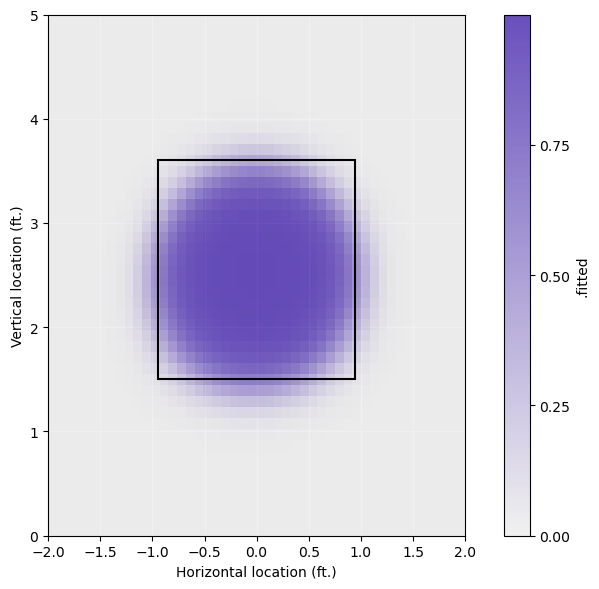

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from src.plotting_utils import add_strike_zone

cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#EBEBEB', '#2905a1'])

fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EBEBEB')

tile = ax.pcolormesh(xx, zz, fitted_grid, 
                     cmap=cmap,
                     alpha=0.7,
                     vmin=0, vmax=1,
                     shading='auto')

add_strike_zone(ax, facecolor='none')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')

cbar = plt.colorbar(tile, ax=ax, label='.fitted')
cbar.set_ticks([0, 0.25, 0.50, 0.75])

ax.grid(True, color='white', linewidth=1)
ax.set_axisbelow(True)

plt.tight_layout()
plt.show()

### 7.4.3 Controlling for handedness

In [20]:
from pygam import LogisticGAM, te, f
import numpy as np

# First, encode the categorical variables as numeric
# p_throws: L=0, R=1
# stand: L=0, R=1
taken_clean['p_throws_encoded'] = (taken_clean['p_throws'] == 'R').astype(int)
taken_clean['stand_encoded'] = (taken_clean['stand'] == 'R').astype(int)

# Prepare the data with all four variables
y = (taken_clean['Outcome'] == 'called_strike').astype(int)
X = taken_clean[['p_throws_encoded', 'stand_encoded', 'plate_x', 'plate_z']].values

# Fit GAM with categorical and smooth terms
# f(0) = factor term for p_throws (not smoothed)
# f(1) = factor term for stand (not smoothed)
# te(2, 3) = tensor smooth for plate_x and plate_z
hand_mod = LogisticGAM(f(0) + f(1) + te(2, 3)).fit(X, y)

In [17]:
import pandas as pd
import numpy as np

# Get unique values for categorical variables
p_throws_values = taken_clean['p_throws'].unique()
stand_values = taken_clean['stand'].unique()

# Create grid for continuous variables
plate_x_range = np.linspace(taken_clean['plate_x'].min(), 
                            taken_clean['plate_x'].max(), 100)
plate_z_range = np.linspace(taken_clean['plate_z'].min(), 
                            taken_clean['plate_z'].max(), 100)

# Create all combinations of the four variables
# This is equivalent to R's data_grid()
from itertools import product

grid_combinations = list(product(plate_x_range, plate_z_range, 
                                p_throws_values, stand_values))

hand_grid = pd.DataFrame(grid_combinations, 
                         columns=['plate_x', 'plate_z', 'p_throws', 'stand'])

# Encode categorical variables for prediction
hand_grid['p_throws_encoded'] = (hand_grid['p_throws'] == 'R').astype(int)
hand_grid['stand_encoded'] = (hand_grid['stand'] == 'R').astype(int)

# Get predictions (augment with fitted values)
X_hand_grid = hand_grid[['p_throws_encoded', 'stand_encoded', 'plate_x', 'plate_z']].values
hand_grid['fitted'] = hand_mod.predict_mu(X_hand_grid)


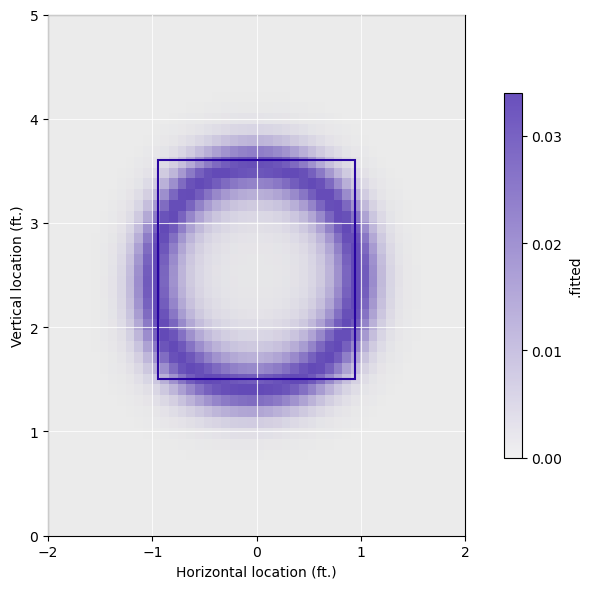

In [19]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Rectangle
import numpy as np

def add_strike_zone(ax, facecolor='none', edgecolor='blue', linewidth=1.5):
    """Add strike zone rectangle to axes."""
    plate_width = 17 + 2 * (9 / np.pi)  # plate width + ball radius
    left = -(plate_width / 2) / 12
    right = (plate_width / 2) / 12
    bottom = 1.5
    top = 3.6
    rect = Rectangle((left, bottom), right - left, top - bottom,
                     facecolor=facecolor, edgecolor=edgecolor, 
                     linewidth=linewidth, zorder=10)
    ax.add_patch(rect)

# Calculate standard deviation of fitted values across the 4 handedness combinations
# Group by location and compute SD
diffs = (hand_grid
    .groupby(['plate_x', 'plate_z'])
    .agg(
        N=('fitted', 'size'),
        fitted_sd=('fitted', 'std')
    )
    .reset_index()
)

# Sort diffs to match the meshgrid order (plate_z varies along rows, plate_x along columns)
# pcolormesh expects Z[i,j] at coordinates (X[j], Y[i])
diffs_sorted = diffs.sort_values(['plate_z', 'plate_x'])
fitted_sd_grid = diffs_sorted['fitted_sd'].values.reshape(100, 100)

# Create the plot matching R's style
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_facecolor('#EBEBEB')

# Create custom colormap matching R's scale_fill_gradient(low = "gray92", high = crcblue)
# gray92 = #EBEBEB, crcblue is the book's blue color
cmap = LinearSegmentedColormap.from_list('gray_to_blue', ['#EBEBEB', '#2905A1'])

# Use imshow instead of pcolormesh for exact tile-like appearance matching R's geom_tile
extent = [plate_x_range.min(), plate_x_range.max(), 
          plate_z_range.min(), plate_z_range.max()]

tile = ax.imshow(fitted_sd_grid, 
                 cmap=cmap,
                 alpha=0.7,
                 extent=extent,
                 origin='lower',
                 aspect='auto',
                 vmin=0,
                 vmax=diffs['fitted_sd'].max())

# Add strike zone
add_strike_zone(ax, facecolor='none', edgecolor='#2905A1', linewidth=1.5)

# Set axis properties
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')

# Add colorbar with label matching R's output
cbar = plt.colorbar(tile, ax=ax, label='.fitted', shrink=0.7)
cbar.set_ticks([0, 0.01, 0.02, 0.03])

# Add white grid lines on top
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_yticks([0, 1, 2, 3, 4, 5])
ax.grid(True, color='white', linewidth=0.8, alpha=0.8)
ax.set_axisbelow(False)

plt.tight_layout()
plt.show()